# 의료 영상 이미지를 이용해 Image segmentation을 진행해보자.
---
### 학습목표
* 위내시경 이미지에 용종을 표시한 데이터를 이용해 모델을 구성하고, 용종을 찾는  Segmentation 모델을 만들어보자.
* 적은 데이터셋을 활용하기 위한 Data augmentation을 진행해보자.
* Encoder-Decoder Model과 U-net 모델을 구현해보자.

## Project 설명
---
### Dataset
* 데이터셋은 [Gastrointestinal Image ANAlys Challenges (GIANA)](https://giana.grand-challenge.org) Dataset (About 650MB) 을 사용했다.
* Data와 labels는 이미지 데이터로 이루어져있으며, 이미지의 상세 스펙은 아래와 같다.
  * Train data: 300 images with RGB channels (bmp format)
  * Train labels: 300 images with 1 channels (bmp format)
  * Image size: 574 x 500
* Training시 **image size는 256**으로 resize해서 사용할 예정이다.

### Baseline code
* Dataset: train, test로 split 해서 이용한다.
* Input data shape: (`batch_size`, 256, 256, 3) RGB color images
* Output data shape: (`batch_size`, 256, 256, 1) Black and white images
* Architecture:
  * 간단한 Encoder-Decoder 구조 구현
  * U-Net 구조 구현
* Training
  * `tf.data.Dataset` 사용
  * `tf.GradientTape()` 사용 for weight update


### Evaluation - MeanIOU
* Image Segmentation에서 많이 쓰이는 평가 기준이다.

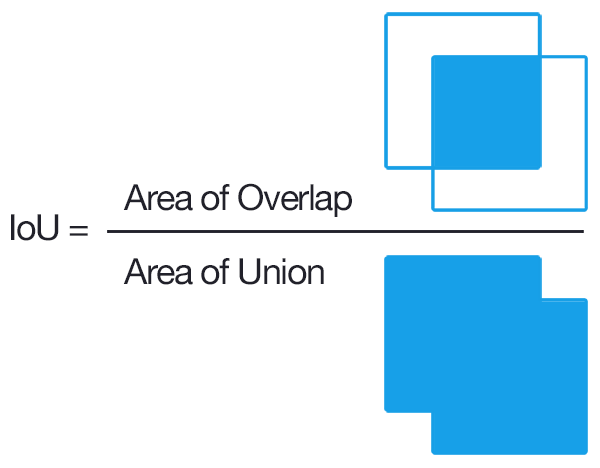


## TF add-on
* 추가 기능을 지원하기위한 add-on 설치

In [1]:
# !pip install tensorflow-addons

In [2]:
use_colab = True
assert use_colab in [True, False]

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### Import base modules

In [4]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)
# 
# from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
# from tensorflow.python.keras import models

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Conv2D, SeparableConv2D, Flatten, Dropout, MaxPooling2D, \
    BatchNormalization, ReLU, GlobalAveragePooling2D
from tensorflow.keras import regularizers

2.10.0


F:\Anaconda3_envs\tensor2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
F:\Anaconda3_envs\tensor2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure 

# 사용 모델 선택
* 학습 및 inference에서 사용할 모델 선택

In [5]:
is_train = True

model_name = 'u-net'
assert model_name in ['ed_model', 'u-net']

## 데이터 수집 및 Visualize

### Download data

이 프로젝트는 [Giana Dataset](https://giana.grand-challenge.org/Dates/)을 이용하여 진행한다.

* 아래 코드를 이용해 Path를 설정한다


In [6]:
if use_colab:
    DATASET_PATH='./'
else:
    DATASET_PATH='./'

### Split dataset into train data and test data
* 다운로드한 데이터셋을 분류해보자.
* 이미지를 직접 로드하는 것이 아닌 데이터의 주소 (data path)를 이용해서 train data와 test data를 분리한다.

In [7]:
dataset_dir = os.path.join(DATASET_PATH) # dataset이 있는 경로

img_dir = os.path.join(dataset_dir, "train") # ./dataset , train => ./dataset/train
label_dir = os.path.join(dataset_dir, "train_labels")

In [8]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)] # 한줄에서 어떤 함수를 동작시키는 방법
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [9]:
print(len(x_train_filenames), len(y_train_filenames))

300 300


In [10]:
print(x_train_filenames[:2])
print(y_train_filenames[:2])

['./train\\1.bmp', './train\\10.bmp']
['./train_labels\\1.bmp', './train_labels\\10.bmp']


In [11]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [12]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### Visualize

데이터 셋에서 5장 (`display_num`)의 이미지를 살펴보자.

In [13]:
# display_num = 5

# r_choices = np.random.choice(num_train_examples, display_num)

# plt.figure(figsize=(10, 15))
# for i in range(0, display_num * 2, 2):
#     img_num = r_choices[i // 2]
#     x_pathname = x_train_filenames[img_num]
#     y_pathname = y_train_filenames[img_num]

#     plt.subplot(display_num, 2, i + 1)
#     plt.imshow(Image.open(x_pathname))
#     plt.title("Original Image")

#     example_labels = Image.open(y_pathname)
#     label_vals = np.unique(example_labels)

#     plt.subplot(display_num, 2, i + 2)
#     plt.imshow(example_labels)
#     plt.title("Masked Image")

# plt.suptitle("Examples of Images and their Masks")
# plt.show()

## Data pipeline and preprocessing 만들기

### Set up hyper-parameters

* Hyper-parameter를 셋팅해보자. 이미지 사이즈, 배치 사이즈 등 training parameter들을 셋팅해보자.
* 직접 이미지 사이즈를 조절할 수 있다.

In [14]:
# Set hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3)

batch_size = 8


if use_colab:
    checkpoint_dir ='./drive/MyDrive/train_ckpt/segmentation/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = './train_ckpt/segmentation/exp1'

### Build our input pipeline with `tf.data`

* tf.data.Dataset을 이용해 input pipeline을 만들어보자.
* map 함수들을 이용해 Data Augmentation을 구현해보자.


#### Our input pipeline will consist of the following steps:

* 아래 방법을 따라서 input pipeline을 만들어보자.

> 1. 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽습니다. 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지입니다.
> 2. 바이트를 이미지 형식으로 디코딩
> 3. 이미지 변환 적용 : (optional, input parameters에 따라서)

> * `resize`-이미지를 표준 크기로 조정합니다 (eda 또는 계산 / 메모리 제한에 의해 결정됨)
> * resize의 이유는 U-Net이 fully convolution networks 이므로 입력 크기에 의존하지 않기 때문입니다. 그러나 이미지 크기를 조정하지 않으면 가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용해야합니다.
> *  성능에 영향을 줄 수 있으므로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정할 수도 있습니다.
> *`hue_delta`-RGB 이미지의 색조를 랜덤 팩터로 조정합니다. 이것은 실제 이미지에만 적용됩니다 (라벨 이미지가 아님). `hue_delta`는`[0, 0.5]`간격에 있어야합니다.
> *`horizontal_flip`-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집습니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.
> *`width_shift_range` 및`height_shift_range`는 이미지를 가로 또는 세로로 임의로 변환하는 범위 (전체 너비 또는 높이의 일부)입니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.
> *`rescale`-이미지를 일정한 비율로 다시 조정합니다 (예 : 1/255.)
> 4. 데이터를 섞고, 데이터를 반복하여 학습합니다.

#### Why do we do these image transformations?

Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉이다.

> 데이터 증가는 여러 무작위 변환을 통해 데이터를 증가시켜 훈련 데이터의 양을 "증가"시킵니다.
> 훈련 시간 동안 우리 모델은 똑같은 그림을 두 번 볼 수 없습니다.
> Overfitting을 방지하고 모델이 처음보는 데이터에 대해 더 잘 일반화되도록 도와줍니다.

#### Processing each pathname
* 위에서 처리한 data path를 이용해 실제 이미지 데이터를 로드하는 함수이다.
* byte 형태로 데이터를 로드하고, bmp로 디코딩한다.
* 디코딩이 완료된 image를 scale과 size를 조절한다.

In [15]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=0) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)
    # 0 ~ 255 RGB 값 ch

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    # 0 기준 초기화 -0.1 ~ 0 ~ 0.3 => 모델 가중치 초기화 범위

    return img, label_img

#### Shifting the image
* 로드한 이미지를 기반으로 이미지의 위치를 이동시키는 함수

In [16]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range: # H, W, C
            width_shift_range = tf.random.uniform([],
                                                -width_shift_range * img_shape[1],
                                                width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                -height_shift_range * img_shape[0],
                                                height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

#### Flipping the image randomly
* 로드한 이미지를 기반으로 이미지를 flip하는 함수

In [17]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))

    return tr_img, label_img

#### Assembling our transformations into our augment function
* 위에서 구현한 Augmentation 함수를 이용해 Data augmentation에 사용하는 함수를 구성한다.

In [18]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.01,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.1,  # Randomly translate the image horizontally
             height_shift_range=0.1):  # Randomly translate the image vertically
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale

    return img, label_img

In [19]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=2,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)

    return dataset

### Set up train and test datasets
* Train dataset에서만 Data augmentation을 진행하게 설정 후 구현한다.

In [20]:
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames)# TODO, # 학습 데이터
                                     # TODO) # 정답 데이터
test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, is_train=False)# TODO,
                                    # TODO,
                                    #is_train=False)

In [21]:
print(train_dataset)
print(test_dataset)
# dataset 나오는데 None, 256, 256 3 // None 256 256 1
#                                   None None None None
# 버전 이슈로 정답 데이터 shape이 정확히 출력되지않는 것으로 예상됩니다.

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, None), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))>


### Plot some train data
* train 데이터를 확인해보자
* data augmentation 이 적용된 이미지를 직접확인해보자.

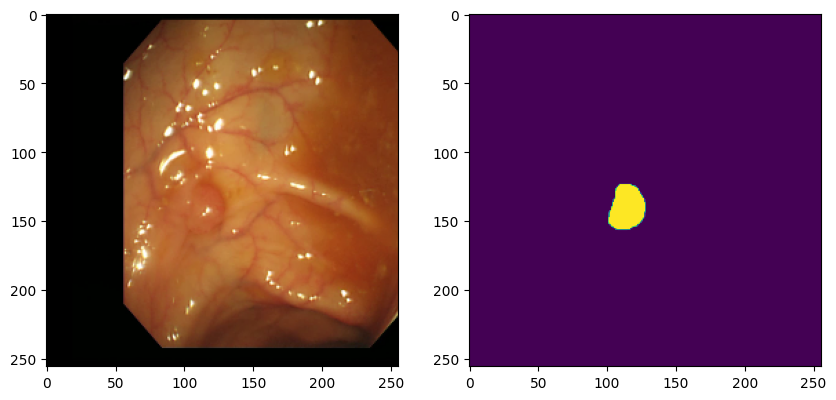

In [22]:
# Colab은 프로세서가 느려서 전처리에 시간이 꽤 걸립니다. 조금 기다려주세요!
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## Build the model

해당 프로젝트는 두 개의 네트워크를 만들어보는 것이 목표이다.
* Encoder-Decoder 스타일의 네트워크

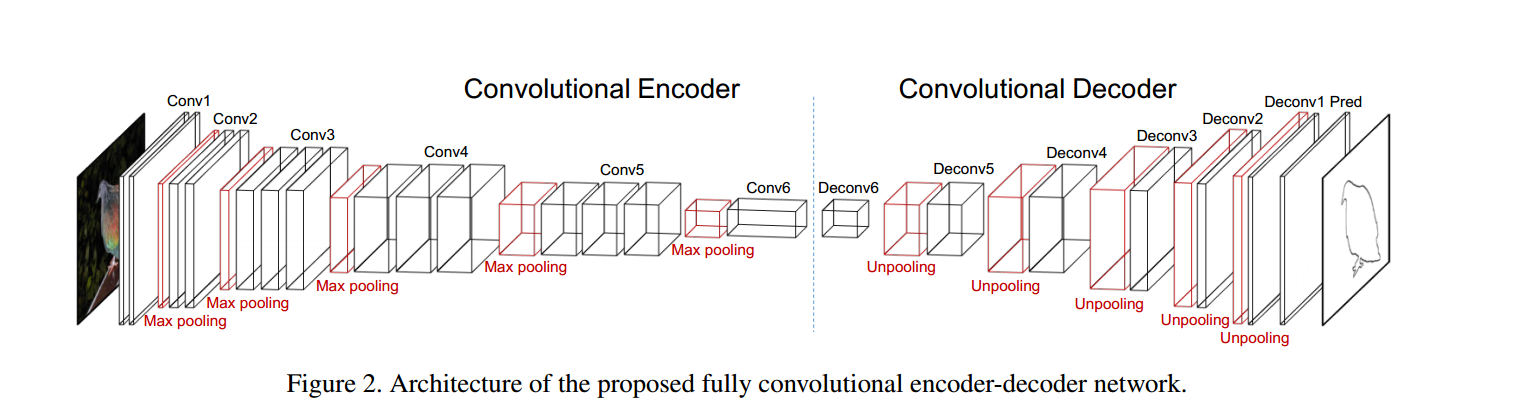


* Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작한다.
* Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label데이터와 같도록 재생성하는 방식으로 학습하게 된다.
    * 우리가 가진 label의 shape과 같은 형태로 데이터를 반환하게 된다.

### Encoder-Decoder architecture

#### Encoder
* 다음과 같은 구조로 Encoder로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = [batch_size, 256, 256, 3]
  * conv1 = [batch_size, 128, 128, 32]
  * conv2 = [batch_size, 64, 64, 64]
  * conv3 = [batch_size, 32, 32, 128]
  * outputs = [batch_size, 16, 16, 256]
* Convolution - Normalization - Activation 등의 조합을 다양하게 생각해보자.
* Pooling을 쓸지 Convolution with stride=2 로 할지 잘 생각해보자.
* `tf.keras.Sequential()`을 이용하여 만들어보자.
  
#### Decoder
* Encoder의 mirror 형태로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = encoder의 outputs = [batch_size, 16, 16, 256]
  * conv_transpose1 = [batch_size, 32, 32, 128]
  * conv_transpose2 = [batch_size, 64, 64, 64]
  * conv_transpose3 = [batch_size, 128, 128, 32]
  * conv_transpose4 = [batch_size, 256, 256, 16]
  * outputs = [batch_size, 256, 256, 1]
* `tf.keras.Sequential()`을 이용하여 만들어보자.

In [23]:
if model_name == 'ed_model':
    encoder = tf.keras.Sequential(name='encoder')
    # # inputs: [batch_size, 256, 256, 3]
    # # conv-batchnorm-activation-maxpool
    # Conv2D(32, 3, padding='same', strides=1 or 2)

    encoder.add(tf.keras.layers.Conv2D(32,3, strides=2, padding='same')) # conv1: [batch_size, 128, 128, 32]
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))

    encoder.add(tf.keras.layers.Conv2D(64,3, strides=2, padding='same')) # conv2: [batch_size, 64, 64, 64]
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))

    encoder.add(tf.keras.layers.Conv2D(128,3, strides=2, padding='same')) # conv3: [batch_size, 32, 32, 128]
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))

    encoder.add(tf.keras.layers.Conv2D(256,3, strides=2, padding='same')) # conv4-outputs: [batch_size, 16, 16, 256]
    encoder.add(tf.keras.layers.BatchNormalization())
    encoder.add(tf.keras.layers.Activation('relu'))

In [24]:
# encoder 제대로 만들어졌는지 확인
if model_name == 'ed_model':
    bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
    print(bottleneck.shape)

In [25]:
if model_name == 'ed_model':
    decoder = tf.keras.Sequential(name='decoder')
    # # inputs: [batch_size, 16, 16, 256]
    decoder.add(tf.keras.layers.Conv2DTranspose(128,3, padding = 'same', strides = 2, input_shape=(16,16,256))) # conv_transpose1: [batch_size, 32, 32, 128]
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))
    decoder.add(tf.keras.layers.Conv2DTranspose(64,3, padding = 'same', strides = 2)) # conv_transpose2: [batch_size, 64, 64, 64]
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))
    decoder.add(tf.keras.layers.Conv2DTranspose(32,3, padding = 'same', strides = 2)) # conv_transpose3: [batch_size, 128, 128, 32]
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))
    decoder.add(tf.keras.layers.Conv2DTranspose(16,3, padding = 'same', strides = 2)) # conv transpose4 [batch_size, 256, 256, 16]
    decoder.add(tf.keras.layers.BatchNormalization())
    decoder.add(tf.keras.layers.Activation('relu'))
    ### output layer
    decoder.add(tf.keras.layers.Conv2DTranspose(1,3, padding = 'same')) # conv output [batch_size, 256, 256, 1]


In [26]:
# decoder 제대로 만들어졌는지 확인
if model_name == 'ed_model':
    predictions = decoder(bottleneck)
    print(predictions.shape)

#### Create a encoder-decocer model

In [27]:
if model_name == 'ed_model': # 최종 모델 구성
    ed_model = tf.keras.Sequential()
    ed_model.add(encoder)
    ed_model.add(decoder)

### U-Net architecture

<img src='https://user-images.githubusercontent.com/11681225/58005153-fd934300-7b1f-11e9-9ad8-a0e9186e751c.png' width="800">

### U-Net
* [U-Net](https://arxiv.org/abs/1505.04597)

> Q. U-Net 구조의 특징은 무엇인가요?
> * FCN 구조를 가지며, skip-connection을 이용해 더 효율적인 학습을 구현할 수 있다.

#### The `tf.keras` Functional API - Model subclassing

* U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않는다. 이럴때는 `tf.keras.Sequential()`을 쓸 수가 없다.

* Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 `tf.keras` functional API 이다.

* Model subclassing 방식은 `tf.keras.Model` 클래스를 상속하여 구현한다.

In [28]:
if model_name == 'u-net':
    class ConvBlock(tf.keras.Model):
        def __init__(self, num_filters, stride=1, kernel_size=3, l2_reg=0.001):
            super(ConvBlock, self).__init__()
            self.num_filters = num_filters
            self.se_conv1 = layers.SeparableConv2D(num_filters, kernel_size, padding='same',
                                                   depthwise_initializer=tf.keras.initializers.he_normal(),
                                                   pointwise_initializer=tf.keras.initializers.he_normal(),
                                                   depthwise_regularizer=regularizers.l2(l2_reg),
                                                   pointwise_regularizer=regularizers.l2(l2_reg))
            self.se_sonv2 = layers.SeparableConv2D(num_filters, kernel_size, padding='same',
                                                   depthwise_initializer=tf.keras.initializers.he_normal(),
                                                   pointwise_initializer=tf.keras.initializers.he_normal(),
                                                   depthwise_regularizer=regularizers.l2(l2_reg),
                                                   pointwise_regularizer=regularizers.l2(l2_reg))
            self.bn1 = BatchNormalization()
            self.bn2 = BatchNormalization()
   
        def call(self, input, stride=1):
            x = self.se_conv1(input)
            x = self.bn1(x)
            x = layers.Activation('relu')(x)
            x = self.se_sonv2(x)
            x = self.bn2(x)
            x = layers.Activation('relu')(x)
            return x
        
if model_name == 'u-net':

    class EncoderBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(EncoderBlock, self).__init__()
            self.conv_block =ConvBlock(num_filters) # TODO
            self.conv1 = layers.Conv2D(num_filters, 3, strides=2, padding='same',
                                       kernel_initializer=tf.keras.initializers.he_normal())

        def call(self, inputs, training=True):
            encoder = self.conv_block(inputs)
            encoder_pool =self.conv1(encoder)
            return encoder_pool, encoder

In [29]:
class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters, l2_reg=0.001):
        super(DecoderBlock, self).__init__()
        self.convT =layers.Conv2DTranspose(num_filters, kernel_size=3, strides=2, padding='same',
                                           kernel_initializer=tf.keras.initializers.he_normal(),
                                           kernel_regularizer=regularizers.l2(l2_reg))
        self.se_conv1 = layers.SeparableConv2D(num_filters, kernel_size=3, padding='same',
                                               depthwise_initializer=tf.keras.initializers.he_normal(),
                                               pointwise_initializer=tf.keras.initializers.he_normal(),
                                               depthwise_regularizer=regularizers.l2(l2_reg),
                                               pointwise_regularizer=regularizers.l2(l2_reg))

        self.bn =  layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()

    def call(self, input_tensor, concat_tensor, training=True): # convT - bn - relu
        decoder = self.convT(input_tensor) # ConvT
        decoder = self.bn(decoder)# bn
        decoder = layers.Activation('relu')(decoder)
        decoder = layers.concatenate([decoder,concat_tensor])# concat
        decoder = self.se_conv1(decoder)
        decoder = self.bn2(decoder)
        decoder = layers.Activation('relu')(decoder)
        return decoder

class OutBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(OutBlock, self).__init__()
      
        self.conv1 = layers.Conv2D(3, 3, strides=1, padding='same',
                                   kernel_initializer=tf.keras.initializers.he_normal())
        self.conv2 = layers.Conv2D(1, 3, strides=1, padding='same',
                                   kernel_initializer=tf.keras.initializers.he_normal())
        self.bn = layers.BatchNormalization()
    def call(self, inputs, training=True):
        x = self.conv1(inputs)
        x = self.bn(x)
        x = layers.Activation('relu')(x)
        x = self.conv2(x)
        return x

In [30]:
if model_name == 'u-net':
    class UNet(tf.keras.Model):
        def __init__(self):
            super(UNet, self).__init__()
            
            self.encoder_block1 = EncoderBlock(num_filters = 32) # 32
            self.encoder_block2 = EncoderBlock(num_filters = 64) # 64
            self.encoder_block3 = EncoderBlock(num_filters = 128) # 128
            self.encoder_block4 = EncoderBlock(num_filters = 128) # 128
            self.encoder_block5 = EncoderBlock(num_filters = 256) # 256
            self.encoder_block6 = EncoderBlock(num_filters = 256) # 256
            self.encoder_block7 = EncoderBlock(num_filters=256)# 256
            self.center = ConvBlock(num_filters=512)# 512 conv b56ck
            self.decoder_block7 = DecoderBlock(num_filters=256)# 256
            self.decoder_block6 = DecoderBlock(num_filters=256)# 256
            self.decoder_block5 = DecoderBlock(num_filters=256)# 256
            self.decoder_block4 = DecoderBlock(num_filters=128)
            self.decoder_block3 = DecoderBlock(num_filters=128)
            self.decoder_block2 = DecoderBlock(num_filters=64)# 64
            self.decoder_block1 = DecoderBlock(num_filters=32)# 32
            self.output_conv = OutBlock(num_filters=1)
        def call(self, inputs, training=True):
            encoder1_pool, encoder1 = self.encoder_block1(inputs)# output 2개
            encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)# output 2개
            encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)# output 2개
            encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)
            encoder5_pool, encoder5 = self.encoder_block5(encoder4_pool)
            encoder6_pool, encoder6 = self.encoder_block6(encoder5_pool)
            encoder7_pool, encoder7 = self.encoder_block7(encoder6_pool)
            center = self.center(encoder7_pool)
            decoder7 = self.decoder_block7(center, encoder7)
            decoder6 = self.decoder_block6(decoder7, encoder6)
            decoder5 = self.decoder_block5(decoder6, encoder5)
            decoder4 = self.decoder_block4(decoder5, encoder4)
            decoder3 = self.decoder_block3(decoder4, encoder3)# input 2개
            decoder2 = self.decoder_block2(decoder3, encoder2)# input 2개
            decoder1 = self.decoder_block1(decoder2, encoder1)# input 2개
            outputs =self.output_conv(decoder1)
            return outputs
        
        def model(self):
            x = tf.keras.Input(shape=(256, 256, 3))
            return tf.keras.Model(inputs=[x], outputs=self.call(x))

UNet().model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_block (EncoderBlock)   ((None, 128, 128, 3  11003       ['input_1[0][0]']                
                                2),                                                               
                                 (None, 256, 256, 3                                               
                                2))                                                               
                                                                                              

#### Create a U-Net model
* 위에서 구현한 Class들을 생성해 최종적으로 U-net 모델을 구현해준다.


In [31]:
if model_name == 'u-net':
    unet_model = UNet()

### Defining custom metrics and loss functions

우리가 사용할 loss function은 다음과 같다.
* binary cross entropy
* dice_loss

* Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가해 사용한다.
> [논문](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf)에 나온 Dice coefficient 수식

$$D = \frac{2 \sum_{i}^{N} p_{i}g_{i}}{\sum_{i}^{N} p_{i}^{2} + \sum_{i}^{N} g_{i}^{2}}$$

> Dice loss를 추가하는 이유는 segmentation task를 더 잘 수행하기위해서이다.

> Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습할 수 있다.

In [32]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [33]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

* Dice Loss가 최대화되는 방향으로 구해지기 때문에, 아래와 같이 사용한다.
* 새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성한다.

In [34]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)

    return loss

In [35]:
optimizer = tf.keras.optimizers.Adam(1e-4)

### Select a model

In [36]:
# model.build(input_shape=(None, 256, 256, 3))

In [37]:
if model_name == 'ed_model':
    print('select the Encoder-Decoder model')
    model = ed_model

if model_name == 'u-net':
    print('select the U-Net model')
    model = unet_model

select the U-Net model


### Checkpoints

In [38]:
if not tf.io.gfile.exists(checkpoint_dir):
    tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

if is_train:
    checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                   model=model)
else:
    checkpoint = tf.train.Checkpoint(model=model)

## Train your model
* 모델 학습 이전에 모델에서 예측한 이미지를 출력할 수 있는 함수를 작성해 모델 성능 테스트에 사용하자.

In [39]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

### Training - `tf.GradientTape()` 함수 이용
* 학습을 진행하며, 위에서 구성한 Train dataset과 Test dataset등을 이용해 학습을 진행한다.
* 학습 데이터의 갯수가 부족하기때문에 Test dataset을 Validation dataset으로 사용한다.

In [40]:
# save loss values for plot
loss_history = []
global_step = 0 # step 수 정의 (선택)

print_steps = 10 # tf.gradient_tape
save_epochs = 5 # tf.gradient_tape
max_epochs = 50
min_loss = float('inf')
################################################################################
for epoch in range(max_epochs):
    for images, labels in train_dataset: # 데이터 로드 파트 ex) data len 240 / batch 100 => 3
        start_time = time.time()
        global_step = global_step + 1

        with tf.GradientTape() as tape: # 모델 학습 파트
            # images [batch_size, 256,256,3]
            predictions = model(images, training=True)
            # label [batch_size, 256, 256, 1]
            loss = bce_dice_loss(labels, predictions)

        # 가중치 업데이트 파트
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

################################################################################
        # 학습 상태 출력
        epochs = global_step * batch_size / float(num_train_examples)
        duration = time.time() - start_time

        if global_step % print_steps == 0:
            clear_output(wait=True)
            examples_per_sec = batch_size  / float(duration)
            print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                        epochs, global_step, loss, examples_per_sec, duration))

            loss_history.append([epoch, loss])

            # print sample image
            for test_images, test_labels in test_dataset.take(1):
                predictions = model(test_images, training=False)

            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[3,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[3, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[3, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

    # # saving (checkpoint) the model periodically
    # if (epoch+1) % save_epochs == 0:
    #     checkpoint.save(file_prefix = checkpoint_prefix)

    # saving (checkpoint) the model periodically if the current loss is lower than the previous saved model's loss
    if (epoch+1) % save_epochs == 0 and loss < min_loss:
        min_loss = loss
        checkpoint.save(file_prefix=checkpoint_prefix)

KeyboardInterrupt: 

### Plot the loss

In [ ]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

#mean = tf.keras.metrics.Mean("mean_iou")
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))
#print("mean_iou: {}".format(mean.result().numpy()))

In [ ]:
loss_history = np.asarray(loss_history)
plt.figure(figsize=(4, 4))
plt.plot(loss_history[:,0], loss_history[:,1])
plt.show()

## Evaluate the test dataset
* 모델을 평가해보자.

* 테스트 데이터셋을 불러와서 meanIoU 값을 구해보자.


* Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인해보자.

In [ ]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

In [ ]:
print_images()